In [34]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib

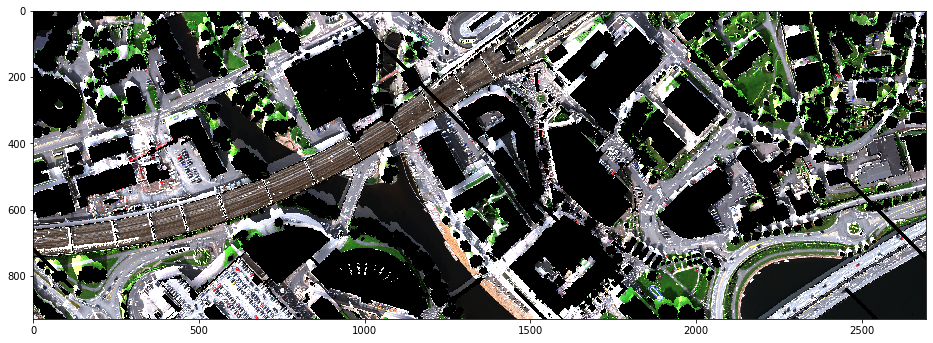

In [35]:
image = envi.open('../../hyperImage/reflectance/09_VNIR_ROAD_MASKED.hdr', '../../hyperImage/reflectance/09_VNIR_ROAD_MASKED.')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [36]:
image.shape

(930, 2694, 186)

In [ ]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

In [ ]:
eigvals = pc_0999.eigenvalues
num_vars = 6


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [ ]:
pc_img = img_pc.load
img_pcc = img_pc[:,:,:3]
img_pcc.shape

In [ ]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

In [3]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(img_pcc.reshape(-1, img_pcc.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, img_pcc.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)
main_df.to_csv('../../hyperImage/csv/features/Ref_vnir_HSI_feature', index=False)



NameError: name 'img_pcc' is not defined

In [3]:
main_df = pd.read_csv('../../hyperImage/csv/features/Ref_vnir_HSI_feature')

In [4]:
## Class image
gt_data = Image.open('../../hyperImage/reflectance/roi/class4.tif')
#gt_data = Image.open('../../hyperImage/reflectance/vnir/training/train_gt2.tif')
gt = np.array(gt_data)
gt.shape

(930, 2694)

In [5]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [6]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]
df_class.shape

(2505420, 1)

# Using only hyperspectral data 

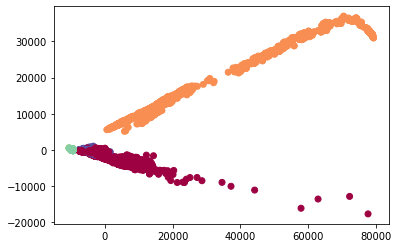

In [7]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

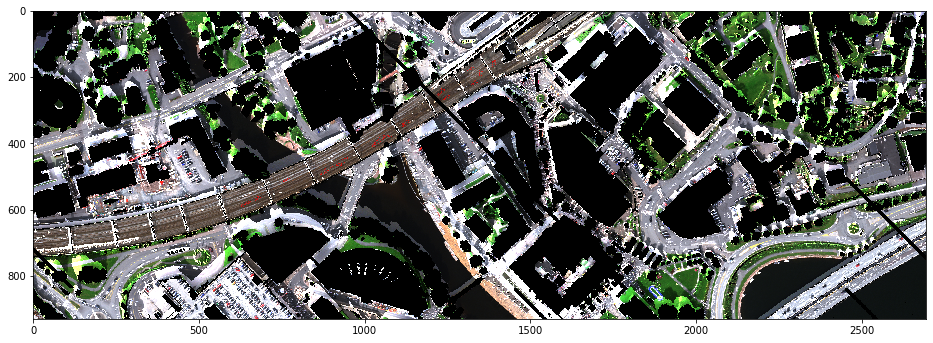

In [8]:
object = (gt == 5).astype(int)
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16), classes=object)
view.set_display_mode('overlay')
view.class_alpha = 0.7
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

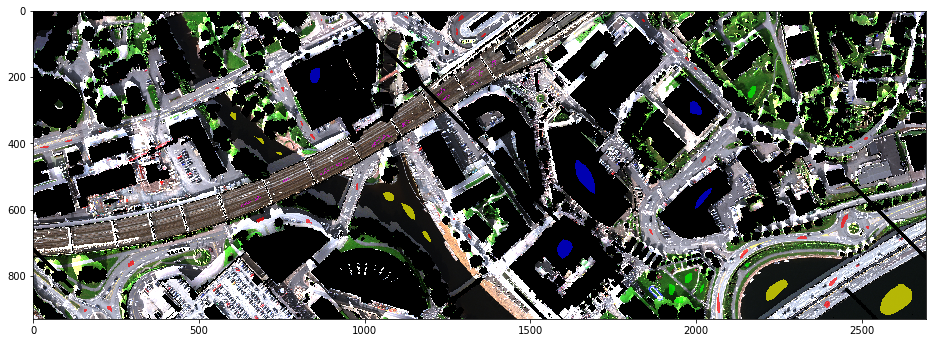

In [9]:
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16), classes=gt)
view.set_display_mode('overlay')
view.class_alpha = 0.7
view.show_data

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [12]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9993093922651933

In [13]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest2.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [15]:
y_pred = random_forest2.predict(X_data_scaled)

In [16]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

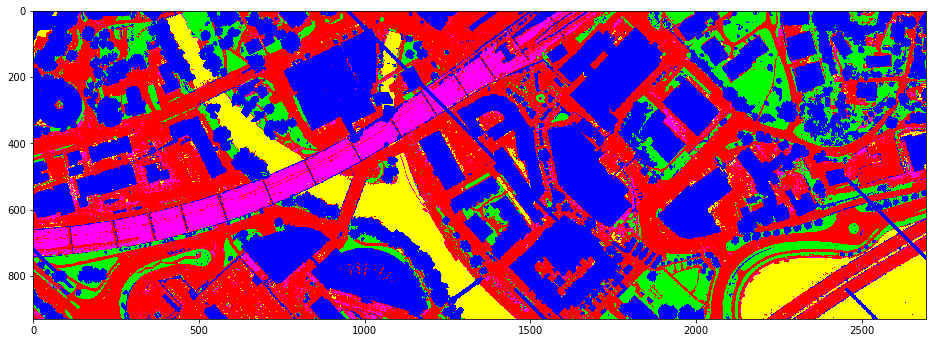

In [17]:
#full_image = envi.open('../hyperImage/reflectance/09_VNIR_POLISHED.hdr', '../hyperImage/reflectance/09_VNIR_POLISHED')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [ ]:
import scipy as sp


# Convenient functions
def compute_energy(proba,classes,beta):
    """
    The function compute the spatial energy terms of the Potts model
    classes: a 3x3 array containing the labels, the considered pixels is in the "middle" classes[1,1]
    proba:  the conditional probabilities of the considered pixels
    beta: the weight parameter
    """

    # Potts model
    count = (classes!=classes[1,1]).sum()

    # Add spectral and spatial energy
    energy = proba + beta*count

    return energy

# Main function
def icm_fit(proba,labels,beta=4,th=0.000001):
    """
    """
    # Get some parameters and do initialization
    diff = [1]
    niter = 0
    [nl,nc,C]=proba.shape

    # Iterate until convergence
    while (diff[-1] > th) and (niter < 100):
        old_labels= labels.copy() # Make a copy of the old labels
        for i in range(1,nl-1): # Scan each line
            for j in range(1,nc-1): # Scan each column
                energy = []
                labels_ = old_labels[i-1:i+2,j-1:j+2].copy()
                for c in range(C): # Compute the energy for the different classes
                    labels_[1,1] = c+1
                    energy.append(compute_energy(proba[i,j,c],labels_,beta))
                arg = sp.argmin(energy) # Get the maximum energy term for the local configuration
                labels[i,j] = arg + 1
        diff.append(1 - sp.sum(old_labels == labels ).astype(float)/nc/nl) # Compute the changes
        niter += 1
    # Clean data
    del old_labels
    return labels

In [ ]:
proba = -random_forest2.predict_log_proba(X_data_scaled).reshape(img.shape[0], img.shape[1],y.max())


In [ ]:
new_labels = icm_fit(proba,predicted_hsi_mask,beta=1.25,th=0.01)

In [ ]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=new_labels)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [18]:
road = (predicted_hsi_mask == 1).astype(int)

In [19]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
from skimage import io
from skimage import img_as_uint
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
viewer = ImageViewer(edges)
viewer.show()
road_edges = edges.astype(int)


/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

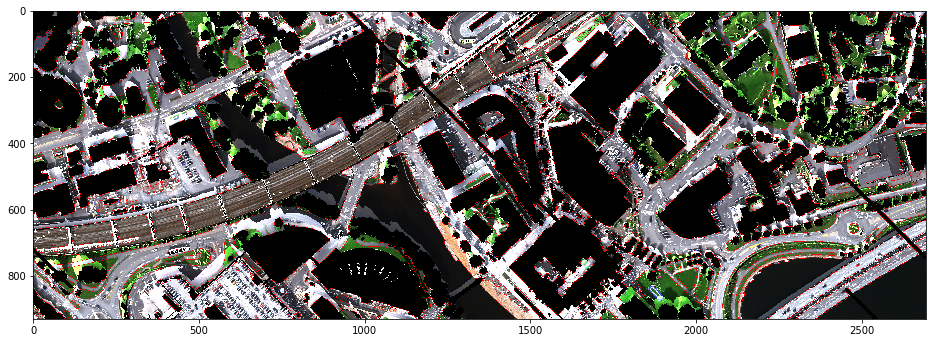

In [20]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# HSI Validation

In [21]:
val_image = envi.open('../../hyperImage/reflectance/vnir/08_clippped_road.hdr', '../../hyperImage/reflectance/vnir/08_clippped_road.')
val_img = val_image.load()
val_img.shape

(799, 2296, 186)

In [22]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/Ref_Vnir_HSI_feature_val')

In [23]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = random_forest.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(val_image.shape[0], val_image.shape[1])

In [24]:
val_full_image = envi.open('../../hyperImage/reflectance/vnir/08_clipped.hdr', '../../hyperImage/reflectance/vnir/08_clipped.')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

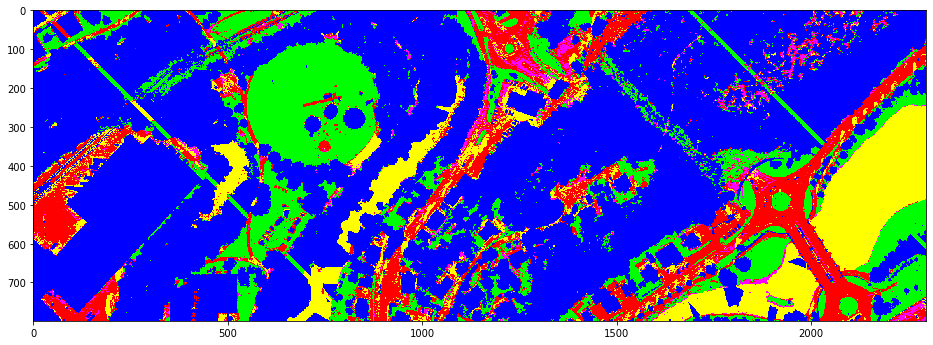

In [25]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [26]:
## Class image
gt_data_val = Image.open('../../hyperImage/reflectance/vnir/class_val.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(799, 2296)

In [27]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(1834504, 1)

In [28]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [29]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values
X_data_scaled_val = scaler.transform(X_val)
y_pred = random_forest.predict(X_data_scaled_val)

In [30]:
accuracy_score(y_val, y_pred)

0.9761684106167225

In [31]:
target_names = ['Road', 'Vegetation', 'Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.99      0.87      0.93     22333
  Vegetation       1.00      0.99      0.99     35000
Unclassified       0.99      1.00      0.99     90474
       Water       0.96      0.98      0.97     37134
 Train Track       0.25      0.85      0.38       653

    accuracy                           0.98    185594
   macro avg       0.84      0.94      0.85    185594
weighted avg       0.98      0.98      0.98    185594



In [32]:
cohen_kappa_score(y_val, y_pred)

0.9645289155547296

In [33]:
confusion_matrix(y_val, y_pred)

array([[19486,     0,   134,  1312,  1401],
       [  125, 34634,    62,     0,   179],
       [   65,   163, 90136,     1,   109],
       [    0,     0,   774, 36360,     0],
       [   85,     0,     0,    13,   555]])

# Using Lidar Data Only

In [33]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/reflectance/roi/masked_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/reflectance/roi/masked_nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [34]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0).all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [35]:
df_lidar

Lidar Intensity  Lidar nDSM  Target
0                -9999.0    -9999.00       0
1                -9999.0    -9999.00       0
2                -9999.0    -9999.00       0
3                -9999.0    -9999.00       0
4                -9999.0    -9999.00       0
...                  ...         ...     ...
2505415              6.0        0.00       0
2505416             11.0        0.03       0
2505417             15.0        0.03       0
2505418             10.0        0.02       0
2505419             14.0        0.00       0

[2505420 rows x 3 columns]

In [36]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [38]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.7908609576427256

In [39]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(930, 2694)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

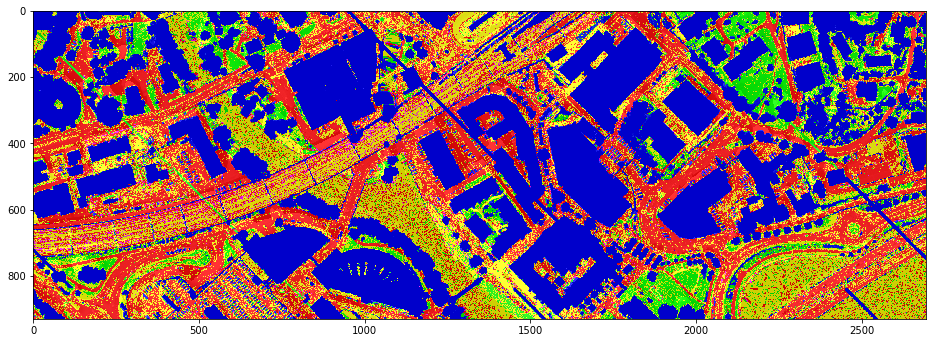

In [41]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data

In [ ]:
road = (predicted_lidar_mask == 1).astype(int)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

In [ ]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

## Lidar Validation

In [42]:
df_lidar_val = pd.read_csv('../../hyperImage/csv/features/Ref_Vnir_lidar_feature_val')

In [43]:
df_lidar_val

Lidar Intensity   Lidar nDSM
0                -9999.0 -9999.000000
1                -9999.0 -9999.000000
2                -9999.0 -9999.000000
3                -9999.0 -9999.000000
4                -9999.0 -9999.000000
...                  ...          ...
1834499             23.0     0.139999
1834500             19.0     0.139999
1834501             13.0     0.120000
1834502             13.0     0.000000
1834503             23.0     0.000000

[1834504 rows x 2 columns]

In [44]:
X_data_scaled = scaler1.transform(df_lidar_val)
val_pred_full = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 858.0]
    G: [0.0, 834.0]
    B: [0.0, 632.0]
>

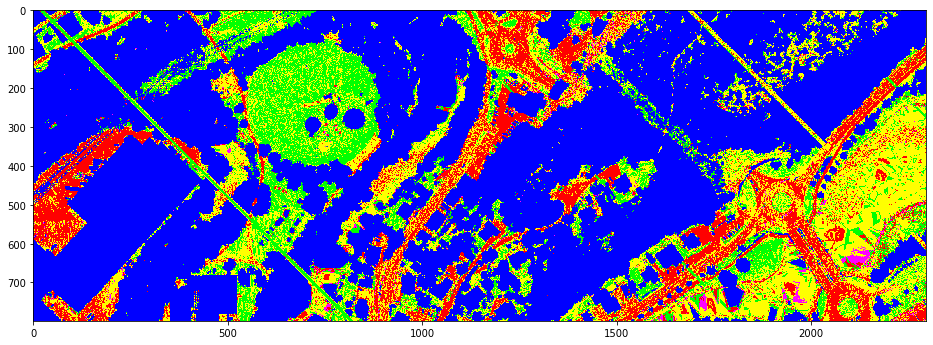

In [45]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [46]:
df_lidar_val_ = pd.concat([df_lidar_val, df_class_val], axis=1, sort=False)
df_lidar_val_

Lidar Intensity   Lidar nDSM  Target
0                -9999.0 -9999.000000       0
1                -9999.0 -9999.000000       0
2                -9999.0 -9999.000000       0
3                -9999.0 -9999.000000       0
4                -9999.0 -9999.000000       0
...                  ...          ...     ...
1834499             23.0     0.139999       0
1834500             19.0     0.139999       0
1834501             13.0     0.120000       0
1834502             13.0     0.000000       0
1834503             23.0     0.000000       0

[1834504 rows x 3 columns]

In [47]:
df_lidar_val_masked = df_lidar_val_[(df_lidar_val_[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [48]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [49]:
accuracy_score(y_val, y_pred)

0.8426242227658222

In [50]:

print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.77      0.71      0.74     22333
  Vegetation       0.82      0.66      0.73     35000
Unclassified       0.99      1.00      0.99     90474
       Water       0.61      0.73      0.66     37134
 Train Track       0.06      0.08      0.07       653

    accuracy                           0.84    185594
   macro avg       0.65      0.64      0.64    185594
weighted avg       0.85      0.84      0.84    185594



In [51]:
confusion_matrix(y_val, y_pred)

array([[15841,   237,    61,  5928,   266],
       [  435, 23203,    46, 11281,    35],
       [   69,    64, 90150,   169,    22],
       [ 3744,  4907,   778, 27137,   568],
       [  408,     4,     3,   183,    55]])

In [52]:
cohen_kappa_score(y_val, y_pred)

0.7652898168921412

# Using  hyperspectral and lidar data 

In [53]:
df_lid_hsi = pd.concat([main_df, df_intensity, df_dsm, df_class], axis=1, sort=False)

In [54]:
df_lid_hsi

PC1         PC2        PC3      NDVI  Lidar Intensity  \
0       -10484.345065  502.798155  88.399638  0.000000          -9999.0   
1       -10484.345065  502.798155  88.399638  0.000000          -9999.0   
2       -10484.345065  502.798155  88.399638  0.000000          -9999.0   
3       -10484.345065  502.798155  88.399638  0.000000          -9999.0   
4       -10484.345065  502.798155  88.399638  0.000000          -9999.0   
...               ...         ...        ...       ...              ...   
2505415  -9499.123350   44.434243 -22.573267 -0.191489              6.0   
2505416  -9608.590817   62.650549 -25.793413 -0.200000             11.0   
2505417  -9588.385036   55.711763 -24.928635 -0.194030             15.0   
2505418  -9599.751759   58.201811 -25.912694 -0.196970             10.0   
2505419  -9672.702881  -19.330094 -19.495562 -0.229630             14.0   

         Lidar nDSM  Target  
0          -9999.00       0  
1          -9999.00       0  
2          -9999.00       0  
3          -9999.00       0  
4          -9999.00       0  
...             ...     ...  
2505415        0.00       0  
2505416        0.03       0  
2505417        0.03       0  
2505418        0.02       0  
2505419        0.00       0  

[2505420 rows x 7 columns]

In [55]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [56]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.9990791896869244

In [58]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [59]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [60]:
y_pred = random_forest3.predict(X_data_scaled)

In [61]:
predicted_hsi_lidar_mask = y_pred.reshape(930, 2694)

In [62]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

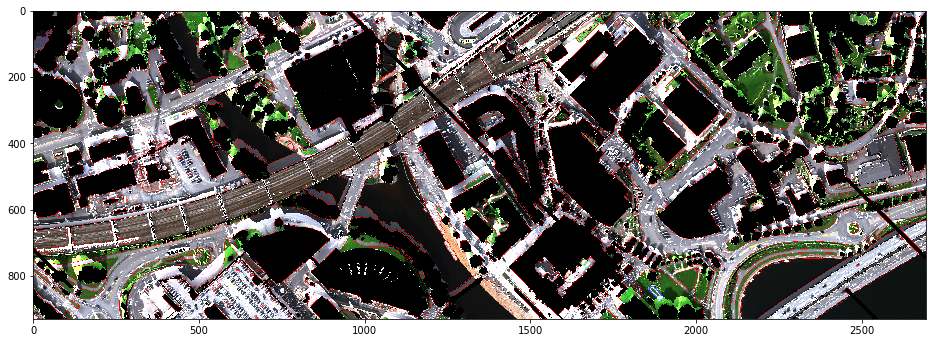

In [64]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1496.0]
    G: [0.0, 1380.0]
    B: [0.0, 1085.0]
>

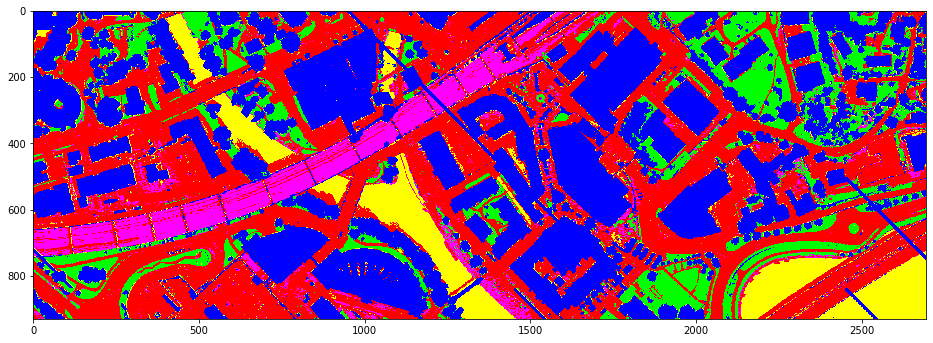

In [65]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data

In [ ]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

In [ ]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

In [ ]:
pc_img = val_img_pc[:,:,:3]
pc_img.shape

In [ ]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df_val = pd.concat([df_pca, df_ndvi], axis=1, sort=False)
main_df_val.to_csv('../../hyperImage/csv/features/Ref_Vnir_HSI_feature_val', index=False)

In [66]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/Ref_Vnir_HSI_feature_val')

In [ ]:
l_intensity_data = Image.open('../../hyperImage/reflectance/vnir/masked_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/reflectance/vnir/masked_nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

df_lidar_val = pd.concat([df_intensity, df_dsm], axis=1, sort=False)
df_lidar_val.to_csv('../../hyperImage/csv/features/Ref_Vnir_lidar_feature_val', index=False)

In [67]:
df_lidar_val = pd.read_csv('../../hyperImage/csv/features/Ref_Vnir_lidar_feature_val')

In [ ]:
df_lidar_val

In [68]:
df_lid_hsi = pd.concat([main_df_val, df_lidar_val], axis=1, sort=False)

In [69]:
df_lid_hsi

PC1          PC2         PC3      NDVI  Lidar Intensity  \
0       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
1       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
2       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
3       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
4       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
...               ...          ...         ...       ...              ...   
1834499   -993.727692 -1130.410607  901.730315 -0.018991             23.0   
1834500    572.654269 -1708.054466  876.050410 -0.013498             19.0   
1834501   1093.990768 -1814.084240  917.140920 -0.013963             13.0   
1834502   -370.617680  -868.101546  772.432134 -0.008360             13.0   
1834503    419.540623  -982.222167  837.524888 -0.010125             23.0   

          Lidar nDSM  
0       -9999.000000  
1       -9999.000000  
2       -9999.000000  
3       -9999.000000  
4       -9999.000000  
...              ...  
1834499     0.139999  
1834500     0.139999  
1834501     0.120000  
1834502     0.000000  
1834503     0.000000  

[1834504 rows x 6 columns]

In [70]:
X_data_scaled = scaler3.transform(df_lid_hsi)

In [71]:
val_pred_full = random_forest3.predict(X_data_scaled)

In [72]:
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 858.0]
    G: [0.0, 834.0]
    B: [0.0, 632.0]
>

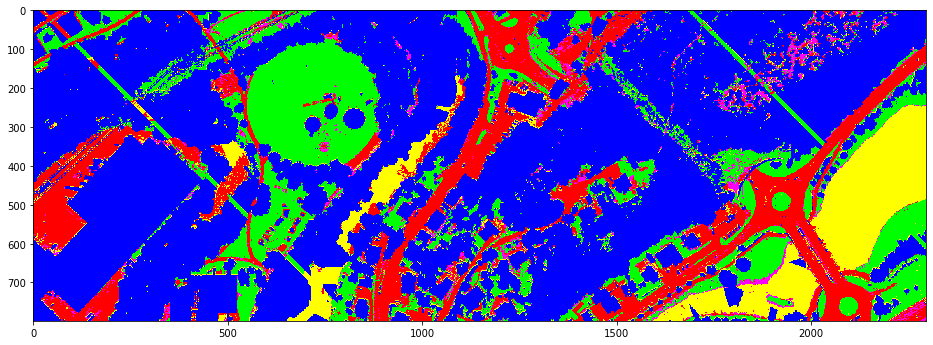

In [73]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [74]:
road = (predicted_hsi_lidar_mask_val == 1).astype(int)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [76]:
val_full_image = envi.open('../../hyperImage/reflectance/vnir/08_clipped.hdr', '../../hyperImage/reflectance/vnir/08_clipped.')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

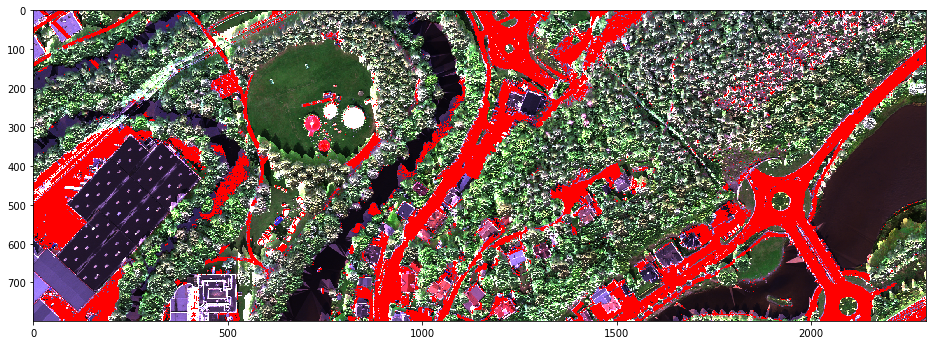

In [77]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [78]:
df_val = pd.concat([df_lid_hsi, df_class_val], axis=1, sort=False)
df_val

PC1          PC2         PC3      NDVI  Lidar Intensity  \
0       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
1       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
2       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
3       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
4       -10484.345065   502.798155   88.399638  0.000000          -9999.0   
...               ...          ...         ...       ...              ...   
1834499   -993.727692 -1130.410607  901.730315 -0.018991             23.0   
1834500    572.654269 -1708.054466  876.050410 -0.013498             19.0   
1834501   1093.990768 -1814.084240  917.140920 -0.013963             13.0   
1834502   -370.617680  -868.101546  772.432134 -0.008360             13.0   
1834503    419.540623  -982.222167  837.524888 -0.010125             23.0   

          Lidar nDSM  Target  
0       -9999.000000       0  
1       -9999.000000       0  
2       -9999.000000       0  
3       -9999.000000       0  
4       -9999.000000       0  
...              ...     ...  
1834499     0.139999       0  
1834500     0.139999       0  
1834501     0.120000       0  
1834502     0.000000       0  
1834503     0.000000       0  

[1834504 rows x 7 columns]

In [79]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = random_forest3.predict(X_data_scaled_val)

In [80]:
accuracy_score(y_val, val_pred_full_)

0.9890513701951572

In [81]:
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.98      0.99      0.99     22333
  Vegetation       1.00      0.99      0.99     35000
Unclassified       0.99      1.00      0.99     90474
       Water       1.00      0.98      0.99     37134
 Train Track       0.41      0.55      0.47       653

    accuracy                           0.99    185594
   macro avg       0.88      0.90      0.89    185594
weighted avg       0.99      0.99      0.99    185594



In [82]:
cohen_kappa_score(y_val, val_pred_full_)

0.9837006467851069

In [83]:
confusion_matrix(y_val, val_pred_full_)

array([[22065,     0,    54,    89,   125],
       [   32, 34643,    54,     8,   263],
       [   58,    92, 90128,    65,   131],
       [    0,     0,   769, 36365,     0],
       [  292,     0,     0,     0,   361]])